<h1>SQL for Data Analysis</h1>
<hr>

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#SQL-Window-Functions" data-toc-modified-id="SQL-Window-Functions-1">SQL Window Functions</a></span><ul class="toc-item"><li><span><a href="#OVER-and-PARTITION-BY-Statements" data-toc-modified-id="OVER-and-PARTITION-BY-Statements-1.1">OVER and PARTITION BY Statements</a></span></li><li><span><a href="#ROW_NUMBER-&amp;-RANK" data-toc-modified-id="ROW_NUMBER-&amp;-RANK-1.2">ROW_NUMBER &amp; RANK</a></span></li></ul></li><li><span><a href="#Aggregates-in-Window-Functions" data-toc-modified-id="Aggregates-in-Window-Functions-2">Aggregates in Window Functions</a></span><ul class="toc-item"><li><span><a href="#Aggregates-in-Window-Functions-with-and-without-ORDER-BY" data-toc-modified-id="Aggregates-in-Window-Functions-with-and-without-ORDER-BY-2.1">Aggregates in Window Functions with and without ORDER BY</a></span></li></ul></li><li><span><a href="#Aliases-for-Multiple-Window-Functions" data-toc-modified-id="Aliases-for-Multiple-Window-Functions-3">Aliases for Multiple Window Functions</a></span></li><li><span><a href="#LAG-and-LEAD-Functions" data-toc-modified-id="LAG-and-LEAD-Functions-4">LAG and LEAD Functions</a></span><ul class="toc-item"><li><span><a href="#Comparing-Rows" data-toc-modified-id="Comparing-Rows-4.1">Comparing Rows</a></span></li><li><span><a href="#Practice-Question" data-toc-modified-id="Practice-Question-4.2">Practice Question</a></span></li></ul></li><li><span><a href="#Percentiles-and-NTILE-Function" data-toc-modified-id="Percentiles-and-NTILE-Function-5">Percentiles and NTILE Function</a></span><ul class="toc-item"><li><span><a href="#Practice-Questions" data-toc-modified-id="Practice-Questions-5.1">Practice Questions</a></span></li></ul></li></ul></div>

## SQL Window Functions

### OVER and PARTITION BY Statements

>A <a href='https://www.postgresql.org/docs/current/tutorial-window.html' target='_blank'>window function</a> performs a calculation across a set of table rows that are somehow related to the current row. This is comparable to the type of calculation that can be done with an aggregate function. But unlike regular aggregate functions, use of a window function does not cause rows to become grouped into a single output row — the rows retain their separate identities. <a href='https://blog.sqlauthority.com/2015/11/04/sql-server-what-is-the-over-clause-notes-from-the-field-101/' target='_blank'>This resource</a> provides additional information.

**Example:**

Create a running total of `standard_amt_usd` (in the `orders` table) over order time with no date truncation. Your final table should have two columns: one with the amount being added for each new row, and a second with the running total.
```sql
SELECT standard_amt_usd,
    SUM(standard_amt_usd) OVER (ORDER BY occurred_at) AS running_total
FROM orders
```

standard_amt_usd | running_total
:----------------|:-------------
0.00 | 0.00
2445.10 | 2445.10
2634.72 | 5079.82


**Example:**

Create a running total of `standard_amt_usd` (in the `orders` table) over order time, but this time, date truncate `occurred_at` by year and partition by that same year-truncated `occurred_at` variable. Your final table should have three columns: One with the amount being added for each row, one for the truncated date, and a final column with the running total within each year.
```sql
SELECT standard_amt_usd,
    DATE_TRUNC('year', occurred_at) as year,
    SUM(standard_amt_usd) OVER (PARTITION BY DATE_TRUNC('year', occurred_at) ORDER BY 
    occurred_at) AS running_total
FROM orders;
```

standard_amt_usd | year | running_total
:----------------|:-----|:-------------
0.00 | 2013-01-01T00:00:00.000Z | 0.00
2445.10 | 2013-01-01T00:00:00.000Z | 2445.10
2634.72 | 2013-01-01T00:00:00.000Z | 5079.82

### ROW_NUMBER & RANK

>`ROW_NUMBER` displays the number of a given row within the window you define. It starts at one and numbers the rows according to the `ORDER BY` part of the window statement.

**Example:**
```sql
SELECT id,
    account_id,
    occurred_at,
    ROW_NUMBER() OVER(ORDER_BY id) AS row_num
FROM orders;
```

id | account_id | occurred_at | row_num
:--|:-----------|:------------|:-------
 1 | 1001 | 2015-10-06 17:31:14 | 1
 2 | 1001 | 2015-11-05 03:34:33 | 2

> `RANK()` : If two lines in a row have the same value for `occurred_at`, they're given the same rank, whereas `ROW_NUMBER` gives them different numbers.
<br>
> `DENSE_RANK()` doesn't skip values after assigning several rows with the same rank

**Example:**
```sql
SELECT id,
  account_id,
  DATE_TRUNC('month', occurred_at) AS month,
  RANK() OVER (PARTITION BY account_id ORDER_BY DATE_TRUNC('month', occurred_at)) AS row_num
FROM orders;
```

id | account_id | month | row_num
:--|:-----------|:------|:-------
1  | 1001       | 2015-10-01 00:00:00 | 1
4307 | 1001     | 2015-11-01 00:00:00 | 2
2    | 1001     | 2015-11-01 00:00:00 | 2

**Example:**

Select the `id`, `account_id`, and `total` variable from the `orders` table, then create a column called `total_rank` that ranks this total amount of paper ordered (from highest to lowest) for each account using a partition. Your final table should have these four columns.
```sql
SELECT id,
    account_id,
    total,
    RANK() OVER (PARTITION BY account_id ORDER BY total DESC) AS total_rank
FROM orders
```

id | account_id | total | total_rank
:--|:-----------|:------|:----------
4308 | 1001 | 1410 | 1
4309 | 1001	| 1405 | 2
4316 | 1001	| 1384 | 3

## Aggregates in Window Functions

**Example:**
```sql
SELECT id, account_id, standard_qty,
  DATE_TRUNC('month', occurred_at) AS month,
  DENSE_RANK() OVER(PARTITION BY account_id ORDER BY DATE_TRUNC('month', occurred_at)) AS dense_rank,
  SUM(standard_qty) OVER(PARTITION BY account_id ORDER BY DATE_TRUNC('month', occurred_at)) AS sum_standard_qty,
  COUNT(standard_qty) OVER(PARTITION BY account_id ORDER BY DATE_TRUNC('month',occurred_at)) AS count_standard_qty,
  AVG(standard_qty) OVER(PARTITION BY account_id ORDER BY DATE_TRUNC('month', occurred_at)) AS avg_standard_qty,
  MIN(standard_qty) OVER(PARTITION BY account_id ORDER BY DATE_TRUNC('month', occurred_at)) AS min_standard_qty,
  MAX(standard_qty) OVER(PARTITION BY account_id ORDER BY DATE_TRUNC('month', occurred_at)) AS max_standard_qty 
FROM orders;
```

id|account_id|standard_qty|month|dense_rank|sum_<br>standard_qty|count_<br>standard_qty|avg_<br>standard_qty|min_<br>standard_qty|max_<br>standard_qty
:-|:---------|:-----------|:----|:---------|:-------------------|:---------------------|:-------------------|:-------------------|:-------------------
1 | 1001 | 123 | 2015-10-01 00:00:00 | 1 | 123 | 1 | 123 | 123 | 123
4307 | 1001 | 506 | 2015-11-01 00:00:00 | 2 | 819 | 3 | 273 | 123 | 506
2 | 1001 | 190 | 2015-11-01 00:00:00 | 2 | 819 | 3 | 273 | 123 | 506
3 | 1001 | 85  | 2015-12-01 00:00:00 | 3 | 1430| 5 | 286 | 85  | 526 

**Note:**
* **sum_standard_quantity**
    * The second and third rows have the same value because they're ordered by the truncated month of occurred_at. Since rows two and three have the same month, they're grouped together.
    
* **count_standard_quantity**
    * Count shows a running count and is grouped in the same way.
    
* **avg_standard_qty**
    * Average shows a running average, which is really just the running sum divided by the running count.
    
* **min_standard_qty**
    * Min shows the lowest value up to that point in the window. 123 is the lowest value until 85 rolls around.
    
* **max_standard_qty**
    * Max works the same way as min, it always shows the max value up to the given row within the current window.

### Aggregates in Window Functions with and without ORDER BY

> The `ORDER BY` clause is one of two clauses integral to window functions. The `ORDER` and `PARTITION` define what is referred to as the “window”—the ordered subset of data over which calculations are made. Removing `ORDER BY` just leaves an unordered partition.

## Aliases for Multiple Window Functions

> To write several window functions in the same query, using the same window, you can create an alias using a **WINDOW** clause. The **WINDOW** clause would normally go between the **WHERE** clause and the **GROUP BY** clause.

> You can check out a complete list of window functions in Postgres (the syntax Mode uses) in the [Postgres documentation.](https://www.postgresql.org/docs/current/functions-window.html)

**Example:**
```sql
SELECT id, account_id, standard_qty,
  DATE_TRUNC('month', occurred_at) AS month,
  DENSE_RANK() OVER main_window AS dense_rank,
  SUM(standard_qty) OVER main_window AS sum_standard_qty,
  COUNT(standard_qty) OVER main_window AS count_standard_qty,
  AVG(standard_qty) OVER main_window AS avg_standard_qty,
  MIN(standard_qty) OVER main_window AS min_standard_qty,
  MAX(standard_qty) OVER main_window AS max_standard_qty 
FROM orders
WINDOW main_window AS (PARTITION BY account_id ORDER BY DATE_TRUNC('month', occurred_at)) 
```
<i>Refer to the earlier example for comparison</i>

## LAG and LEAD Functions

> **LAG** returns the value from the row preceding the current row in the table.<br><br>
> **LEAD** returns the value from the row following the current row in the table.

### Comparing Rows

```sql
SELECT account_id, standard_sum,
  LAG(standard_sum) OVER(ORDER BY standard_sum) AS lag,
  LEAD(standard_sum) OVER(ORDER BY standard_sum) AS lead,
  standard_sum - LAG(standard_sum) OVER(ORDER BY standard_sum) AS lag_difference,
  LEAD(standard_sum) OVER(ORDER BY standard_sum) - standard_sum AS lead_difference
FROM (
    SELECT account_id,
      SUM(standard_qty) AS standard_sum
    FROM orders
    GROUP BY 1
      ) sub
```

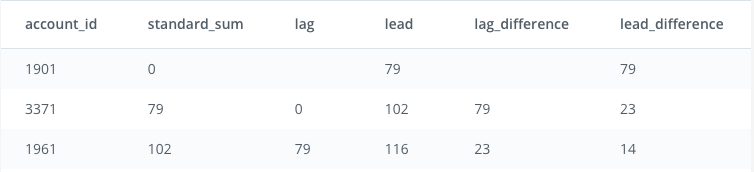

**Note:** <i>**LAG** difference shows the difference between the current row and the prior row.<br>
**LEAD** difference shows the difference between the current row and the next row.</i>


### Practice Question

The above technique can be useful when analyzing time-based events. Imagine you're an analyst at Parch & Posey and you want to determine how the current order's total revenue ("total" meaning from sales of all types of paper) compares to the next order's total revenue.
```sql
SELECT occurred_at,
  total_amt_usd,
  LEAD(total_amt_usd) OVER (ORDER BY occurred_at) AS lead,
  LEAD(total_amt_usd) OVER (ORDER BY occurred_at) - total_amt_usd AS lead_difference
FROM (
  SELECT occurred_at,
    SUM(total_amt_usd) AS total_amt_usd
  FROM orders 
  GROUP BY 1
  ) sub
```

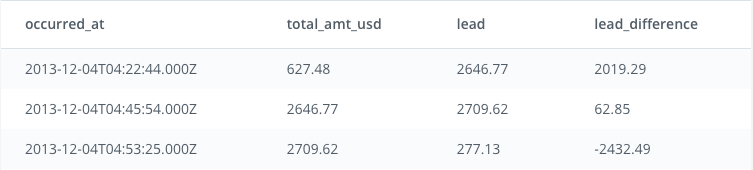

## Percentiles and NTILE Function

> The **NTILE** function allows you to see the percentile or any other subdivision that a given row falls into. <br><br>
> The number specified in the **NTILE** function is the number of parts into which the window is divided.
    > + 100 means percentiles
    > + 5 means quintiles
    > + 4 means quartiles

**Example:**
```sql
SELECT id, account_id, occurred_at, standard_qty,
  NTILE(4) OVER(ORDER BY standard_qty) AS quartile,
  NTILE(5) OVER(ORDER BY standard_qty) AS quintile,
  NTILE(100) OVER(ORDER BY standard_qty) AS percentile
FROM orders
ORDER BY standard_qty DESC;
```
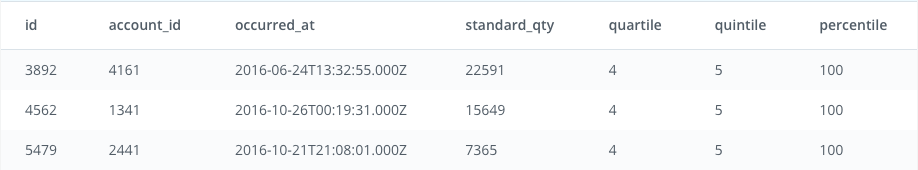

**Note:** <i> For each row, the NTILE four function will look at the value of standard quantity in that row compared to all the other rows in the window and then print the quartile that the value falls into. For example, a standard quantity of zero would fall in the first quartile, while the highest value would fall in the fourth quartile.</i>

**Expert Tip**  

In cases with relatively few rows in a window, the `NTILE` function doesn’t calculate exactly as you might expect. For example, If you only had two records and you were measuring percentiles, you’d expect one record to define the 1st percentile, and the other record to define the 100th percentile. Using the `NTILE` function, what you’d actually see is one record in the 1st percentile, and one in the 2nd percentile.

In other words, when you use a NTILE function but the number of rows in the partition is less than the NTILE(number of groups), then NTILE will divide the rows into as many groups as there are members (rows) in the set but then stop short of the requested number of groups. If you’re working with very small windows, keep this in mind and consider using quartiles or similarly small bands.

You can check out a complete list of window functions in Postgres (the syntax Mode uses) in the [Postgres documentation.](https://www.postgresql.org/docs/current/functions-window.html)

### Practice Questions  
You want to determine the largest orders (in terms of quantity) a specific customer has made to encourage them to order more similarly sized large orders. You only want to consider the NTILE for that customer's account_id.  

Write three queries (separately) that reflect each of the following:  
1. Use the `NTILE` functionality to divide the accounts into 4 levels in terms of the amount of `standard_qty` for their orders. Your resulting table should have the `account_id`, the `occurred_at` time for each order, the total amount of `standard_qty` paper purchased, and one of four levels in a `standard_quartile` column.
```sql
SELECT account_id, occurred_at, standard_qty,
  NTILE(4) OVER (PARTITION BY account_id ORDER BY standard_qty) AS standard_quartile
FROM orders 
ORDER BY account_id DESC
```
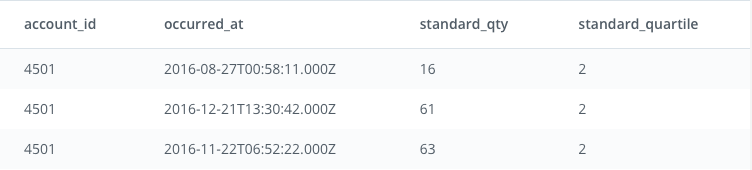

2. Use the `NTILE` functionality to divide the accounts into two levels in terms of the amount of `gloss_qty` for their orders. Your resulting table should have the `account_id`, the `occurred_at` time for each order, the total amount of `gloss_qty` paper purchased, and one of two levels in a `gloss_half` column. 
```sql
SELECT account_id, occurred_at, gloss_qty,
  NTILE(2) OVER (PARTITION BY account_id ORDER BY gloss_qty) AS gloss_half
FROM orders 
ORDER BY account_id DESC
```
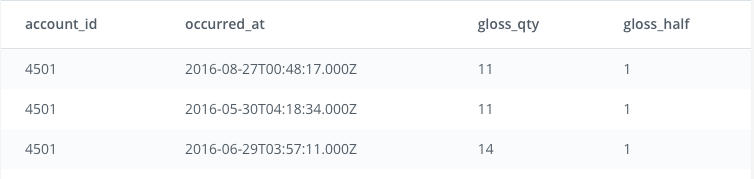

3. Use the `NTILE` functionality to divide the orders for each account into 100 levels in terms of the amount of `total_amt_usd` for their orders. Your resulting table should have the `account_id`, the `occurred_at` time for each order, the total amount of `total_amt_usd` paper purchased, and one of 100 levels in a `total_percentile` column.
```sql
SELECT account_id, occurred_at, total_amt_usd,
  NTILE(100) OVER(PARTITION BY account_id ORDER BY total_amt_usd) AS total_percentile
FROM orders
ORDER BY account_id DESC;
```
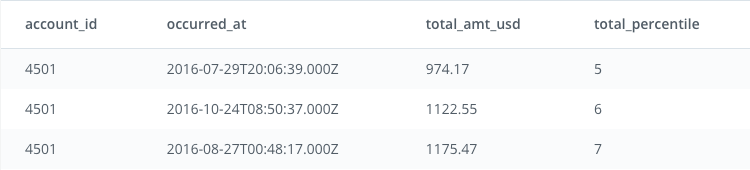